In [1]:
import numpy as np

data = np.load("/Users/dongbaiqi/Desktop/Tang Lab/Spatially_aware_dimensionality_reduction/PythonProject/data/fish_data.npz")
spks = data['spks']
xyz = data['xyz']

In [17]:
# trial 1
# print(data['stims'][20:480])

In [18]:
# trial 2
# print(data['stims'][500:960])

In [19]:
# print(data['stims'][2690:3150])

In [20]:
# print(data['stims'][3170:3630])

In [21]:
# trial 3
# print(data['stims'][5240: 5700])

In [22]:
# trial 4
# print(data['stims'][5720: 6180])

In [3]:
n_neurons = spks.shape[0]
np.random.seed(42)
selected_idx = np.random.choice(n_neurons, size=1000, replace=False)

X_all      = spks[selected_idx, :]
coords_np      = xyz[selected_idx, :]

In [4]:
trial1 = X_all[:, 20:480]
print("trial 1 shape: ", trial1.shape)
trial2 = X_all[:, 500:960]
print("trial 2 shape: ", trial2.shape)
trial3 = X_all[:, 5240: 5700]
print("trial 3 shape: ", trial3.shape)
trial4 = X_all[:, 5720: 6180]
print("trial 4 shape: ", trial4.shape)

X_cat = np.concatenate((trial1, trial2, trial3, trial4), axis=1)
print(X_cat.shape)

trial 1 shape:  (1000, 460)
trial 2 shape:  (1000, 460)
trial 3 shape:  (1000, 460)
trial 4 shape:  (1000, 460)
(1000, 1840)


In [5]:
def cosine_similarity_matrix(X):
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)
    return np.dot(X_norm, X_norm.T)


func_mat_np = cosine_similarity_matrix(X_cat)

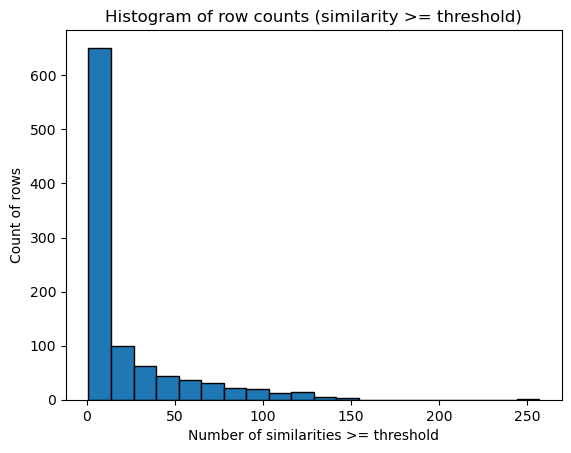

In [6]:
# func_mat inspection to choose threshold
# use 0.2
import matplotlib.pyplot as plt

stat = func_mat_np >= 0.3
stat = stat.sum(axis=1)
plt.figure()
plt.hist(stat, bins=20, edgecolor='black')
plt.xlabel("Number of similarities >= threshold")
plt.ylabel("Count of rows")
plt.title("Histogram of row counts (similarity >= threshold)")
plt.show()

(1000,)
43.64630568559039


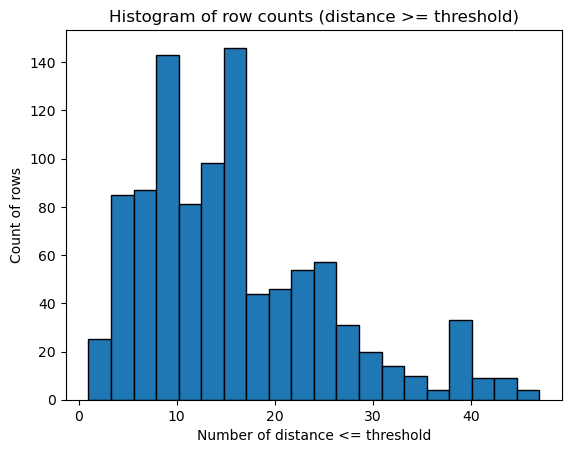

In [7]:
# distance inspection to choose threshold

# Use 70
from scipy.spatial.distance import cdist
dist = cdist(coords_np, coords_np, metric='euclidean')
dist_stat = 10000 * np.eye(1000) + dist
min = dist_stat.min(axis=0)
print(min.shape)
print(min.max())

dist_stat = dist <= 40
dist_stat = dist_stat.sum(axis=1)
plt.figure()
plt.hist(dist_stat, bins=20, edgecolor='black')
plt.xlabel("Number of distance <= threshold")
plt.ylabel("Count of rows")
plt.title("Histogram of row counts (distance >= threshold)")
plt.show()

In [8]:
N = X_cat.shape[0]
T = X_cat.shape[1]

X_train = X_cat.reshape(N, 4, T//4)
print(X_train.shape)

(1000, 4, 460)


In [9]:
import numpy as np
import torch

from model.train import train_trace_with_custom_pairs

# ============ 0) data preparation ============
def to_float_tensor(x):
    if isinstance(x, np.ndarray):
        return torch.from_numpy(x).float()
    elif isinstance(x, torch.Tensor):
        return x.float()
    else:
        raise TypeError("X_train / X_test must be numpy.ndarray or torch.Tensor")

X_train_t = to_float_tensor(X_train)  # [N, R, T]

N, R, T = X_train_t.shape
print(f"[info] X_train: N={N}, R={R}, T={T}")

# random seed
torch.manual_seed(0)
np.random.seed(0)

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[info] device:", device)

# ============ 1) spatial/functional prior ============
# coords   = None         # torch.Tensor [N,2] or [N,3]
func_vec = None         # torch.Tensor [N]
# func_mat = None         # torch.Tensor [N,N]

# uncomment if you have
coords   = torch.from_numpy(coords_np).float()
# func_vec = torch.from_numpy(func_vec_np).float()
func_mat = torch.from_numpy(func_mat_np).float()

# ============ 2) training ============
k = max(1, R // 2)

epochs     = 1500
batch_size = 200
lr         = 1e-3
proj_mode  = "large"

model, history = train_trace_with_custom_pairs(
    X=X_train_t,
    T=T,
    #coords=coords,           # None or [N,2/3]
    coords=None,
    func_vec=None,       # None or [N]
    #func_mat=func_mat,       # None or [N,N]
    func_mat=None,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    k=k,
    r_max=100,              # spatial constraint
    f_pos_th=0.5,            # functional threshold
    same_sign=True,          # this is only func_vec
    proj_mode=proj_mode,
    device=device,
    grad_clip=5.0,
    log_every=5,
    return_history=True,
)

print(f"[done] training finished. logged {len(history['loss'])} loss points.")

[info] X_train: N=1000, R=4, T=460
[info] device: cpu
[warn] coords/func is not provided, only depends TRACE's positive pair of two views
[epoch 001] mean loss = 5.834108 (batches=5)
[epoch 002] mean loss = 5.538480 (batches=5)
[epoch 003] mean loss = 5.300674 (batches=5)
[epoch 004] mean loss = 5.142929 (batches=5)
[epoch 005] mean loss = 5.066781 (batches=5)
[epoch 006] mean loss = 4.984436 (batches=5)
[epoch 007] mean loss = 4.951188 (batches=5)
[epoch 008] mean loss = 4.822831 (batches=5)
[epoch 009] mean loss = 4.752832 (batches=5)
[epoch 010] mean loss = 4.635893 (batches=5)
[epoch 011] mean loss = 4.585636 (batches=5)
[epoch 012] mean loss = 4.640332 (batches=5)
[epoch 013] mean loss = 4.579754 (batches=5)
[epoch 014] mean loss = 4.476997 (batches=5)
[epoch 015] mean loss = 4.530504 (batches=5)
[epoch 016] mean loss = 4.444837 (batches=5)
[epoch 017] mean loss = 4.422685 (batches=5)
[epoch 018] mean loss = 4.312800 (batches=5)
[epoch 019] mean loss = 4.270968 (batches=5)
[epoch 

In [10]:
# ============ 3) inference ============
# training set
with torch.no_grad():
    Xm_train = X_train_t.mean(dim=1).to(device)  # [N, T]
    h_train, u_train = model(Xm_train)           # h:[N,128], u:[N,2]
    h_train = h_train.cpu().numpy()
    u_train = u_train.cpu().numpy()

print("[done] embeddings ready:",
      f"h_train {h_train.shape}, u_train {u_train.shape}")

[done] embeddings ready: h_train (1000, 128), u_train (1000, 2)


In [11]:
# Save
np.savez("./", emb=u_train, coords=coords_np)